In [3]:
import yt
import pyxsim
import h5py
import numpy as np
import illustris_python as il
from numba import jit
import pylab as plt
from yt import derived_field

soxs : [WARNING  ] 2025-05-19 04:53:13,064 Setting 'soxs_data_dir' to /home/tnguser/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [4]:
basePath = "../../../sims.TNG/TNG50-1/output/"
snap = 50                                                       #z=1
nbins = 20
r_norm_min = 1e-2
r_norm_max = 2
haloID = 1234
label = "try"

In [5]:
print(f"Processing {label} halo {haloID}...")
halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)

header = il.groupcat.loadHeader(basePath, snap)
gas = il.snapshot.loadHalo(basePath, snap, haloID, "gas")
with h5py.File(il.snapshot.snapPath(basePath, snap), 'r') as f:
    header_snap = dict(f['Header'].attrs)

filename = f"halo_{label}_{haloID}.hdf5"
with h5py.File(filename, 'w') as f:
    for key in gas.keys():
        f['PartType0/' + key] = gas[key]
    f.create_group('Header')
    f['Header'].attrs['NumFilesPerSnapshot'] = 1
    f['Header'].attrs['MassTable'] = header_snap['MassTable']
    f['Header'].attrs['BoxSize'] = header['BoxSize']
    f['Header'].attrs['Time'] = header['Time']
    f['Header'].attrs['Redshift'] = header['Redshift']
    f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])
    f['Header'].attrs['HubbleParam'] = header['HubbleParam']
    f['Header'].attrs['Omega0'] = header['Omega0']
    f['Header'].attrs['OmegaLambda'] = header['OmegaLambda']
    f['Header'].attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
    f['Header'].attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
    f['Header'].attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

@yt.derived_field(name="radius_r200", units="", sampling_type="cell", force_override=True)
def _radius_r200(field, data):
    r1 = np.linalg.norm(data["PartType0", "Coordinates"].to("kpc") - c, axis=1)
    return  r1 / r200

@yt.derived_field(name="cell_volume2", units="kpc**3", sampling_type="cell",force_override=True)
def _cell_volume2(field, data):
    mass = data["gas", "mass"]
    density = data["gas", "density"]
    return (mass/density).to("kpc**3")
'''
@yt.derived_field(name="cell_volumePART2", units="kpc**3", sampling_type="cell")
def _cell_volumePART2(field, data):
    mass = data["PartType0", "Masses"].to("Msun")
    density = data["PartType0", "Density"].to("Msun/kpc**3")
    return (mass/density)#.to("kpc**3")
'''
ds = yt.load(filename)

c = ds.arr(halo["GroupPos"], "code_length").to("kpc")
r200a = ds.arr(halo["Group_R_Crit200"], "code_length").to("kpc")
r200 = r200a.to_value("kpc") 
del halo, header, gas

sp = ds.sphere(c, r_norm_max * r200)
radii = np.linalg.norm(sp["PartType0", "Coordinates"].to("kpc") - c, axis=1)/ r200
hsml = ds.arr(sp["PartType0", "SubfindHsml"], "code_length").to("kpc")/ r200

radii2 = np.linalg.norm(sp["PartType0", "Coordinates"].to("kpc") - c, axis=1)
hsml2 = ds.arr(sp["PartType0", "SubfindHsml"], "code_length").to("kpc") 

#r_bins = np.linspace(0, r_norm_max, nbins + 1)
r_bins = np.logspace(np.log10(r_norm_min), np.log10(r_norm_max), nbins + 1)
r_bins_kpc = np.logspace(np.log10(r_norm_min * r200), np.log10(r_norm_max * r200), nbins + 1)

Processing try halo 1234...


yt : [INFO     ] 2025-05-19 04:53:18,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 04:53:18,558 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 04:53:18,560 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 04:53:18,561 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 04:53:18,562 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-19 04:53:18,563 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 04:53:18,564 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 04:53:18,566 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 04:53:18,566 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 04:53:18,567 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 04:53:18,568 Parameters: hubble_consta

## Option 1: Using B2 Spline Smoothing

### 🔍 B2 Spline Kernel Function

The **B2 spline kernel** \( W(r, h) \) used in SPH (Smoothed Particle Hydrodynamics) is defined as:

$$
W(r, h) = \frac{7}{\pi h^3 \cdot 8} \times
\begin{cases}
1 - 6q^2 + 6q^3, & \text{if } 0 \leq q < 0.5 \\\\
2(1 - q)^3, & \text{if } 0.5 \leq q < 1.0 \\\\
0, & \text{if } q \geq 1.0
\end{cases}
$$

where $q = \frac{r}{h}$ , \( r \) is the distance between particles, and \( h \) is the smoothing length.

---

### 🧮 Weighted Average (Smoothed Value)

The smoothed value at a location \( r \) using the kernel weights is given by:

$$
\bar{A}(r) = \frac{\sum\limits_{i} A_i \cdot W(|r - r_i|, h_i)}{\sum\limits_{i} W(|r - r_i|, h_i)}
$$

where:

- \( A_i \) is the value (e.g., temperature, density) of particle \( i \),
- \( r_i \) is the position of particle \( i \),
- \( h_i \) is its smoothing length,
- and \( W \) is the B2 spline kernel.


In [6]:
@jit(nopython=True)
def W_B2(r, h):
    q = r / h
    W = np.zeros_like(r)
    factor = ( 7.0 * np.pi )/ (8 * h**3)

    mask1 = (q >= 0) & (q < 0.5)
    mask2 = (q >= 0.5) & (q < 1.0)

    W[mask1] = factor[mask1] * (1 - 6*q[mask1]**2 + 6*q[mask1]**3)
    W[mask2] = factor[mask2] * (2 * (1 - q[mask2])**3)
    return W

def sph_smooth_b2_vectorized(radii, values, hsml, r_bins):    

    #r_bin_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    r_bin_centers = np.sqrt(r_bins[:-1] * r_bins[1:])
    
    smoothed = np.zeros(len(r_bin_centers))
    weights = np.zeros(len(r_bin_centers))
    
    for i, r_center in enumerate(r_bin_centers):
        dr = np.abs(radii - r_center)  # Distances to all particles
        mask = dr <= hsml
        if np.any(mask):
            w = W_B2(dr[mask], hsml[mask])
            smoothed[i] = np.sum(values[mask] * w)
            weights[i] = np.sum(w)

        if weights[i] == 0:
            print(f"Warning: Bin {i} has zero total weight.")
    smoothed = np.divide(smoothed, weights, out=np.zeros_like(smoothed), where=weights > 0)    
    return smoothed

In [7]:
temp_scaled = sph_smooth_b2_vectorized(radii, sp["gas", "temperature"].to("K").value, hsml, r_bins)
temp_unscaled = sph_smooth_b2_vectorized(radii2, sp["gas", "temperature"].to("K").value, hsml2, r_bins_kpc)

## Option 2: Just Using Average

In [8]:
def bin_profile(quantity):
    binned = np.array([
        np.mean(quantity[(radii >= r_bins[i]) & (radii < r_bins[i+1])])
        if np.any((radii >= r_bins[i]) & (radii < r_bins[i+1])) else np.nan
        for i in range(nbins)
    ])
    return np.nan_to_num(binned, nan=0.0)
    #return binned

temp2 = bin_profile(sp["gas", "temperature"].to("K"))

## Option 3: Median

In [9]:
def bin_profile(quantity):
    binned = np.array([
        np.median(quantity[(radii >= r_bins[i]) & (radii < r_bins[i+1])])
        if np.any((radii >= r_bins[i]) & (radii < r_bins[i+1])) else np.nan
        for i in range(nbins)
    ])
    return np.nan_to_num(binned, nan=0.0)
    #return binned

temp3 = bin_profile(sp["gas", "temperature"].to("K"))

## Option 4: Volume Weighted Average

In [10]:
volumes = (sp["PartType0", "Masses"].to("Msun") / sp["PartType0", "Density"].to("Msun/kpc**3"))

def calculate_volume_weighted_profile(quantity):
    profile = np.zeros(len(r_bins)-1)
    total_volume = np.zeros(len(r_bins)-1)
    
    for i in range(len(r_bins)-1):
        mask = (radii >= r_bins[i]) & (radii < r_bins[i+1])
        if np.any(mask):
            profile[i] = np.sum(quantity[mask] * volumes[mask])
            total_volume[i] = np.sum(volumes[mask])
    
    return np.divide(profile, total_volume, out=np.zeros_like(profile), where=total_volume>0)

temp4 = calculate_volume_weighted_profile(sp["PartType0", "Temperature"].to("K").value)

## Option 5: Mass Weighted Average

In [11]:
masses = sp["PartType0", "Masses"].to("Msun")

def calculate_mass_weighted_profile(quantity):
    profile = np.zeros(len(r_bins)-1)
    total_mass = np.zeros(len(r_bins)-1)
    
    for i in range(len(r_bins)-1):
        mask = (radii >= r_bins[i]) & (radii < r_bins[i+1])
        if np.any(mask):
            profile[i] = np.sum(quantity[mask] * masses[mask])
            total_mass[i] = np.sum(masses[mask])
    
    return np.divide(profile, total_mass, out=np.zeros_like(profile), where=total_mass>0)

temp5 = calculate_mass_weighted_profile(sp["PartType0", "Temperature"].to("K").value)

## Option 6: yt Profile1D

In [12]:
prof = yt.Profile1D(sp, ("gas", "radius_r200"), nbins, r_norm_min, r_norm_max, True, weight_field=("gas", "cell_volume2"))
prof.add_fields([("gas", "temperature")])
x = prof.x
temp_yt_volume = prof[("gas", "temperature")] 

In [13]:
prof3 = yt.Profile1D(sp, ("gas", "radius_r200"), nbins, r_norm_min, r_norm_max, True, weight_field=("gas", "mass"))
prof3.add_fields([("gas", "temperature")])
temp_yt_mass = prof3[("gas", "temperature")] 

## Comparing Both

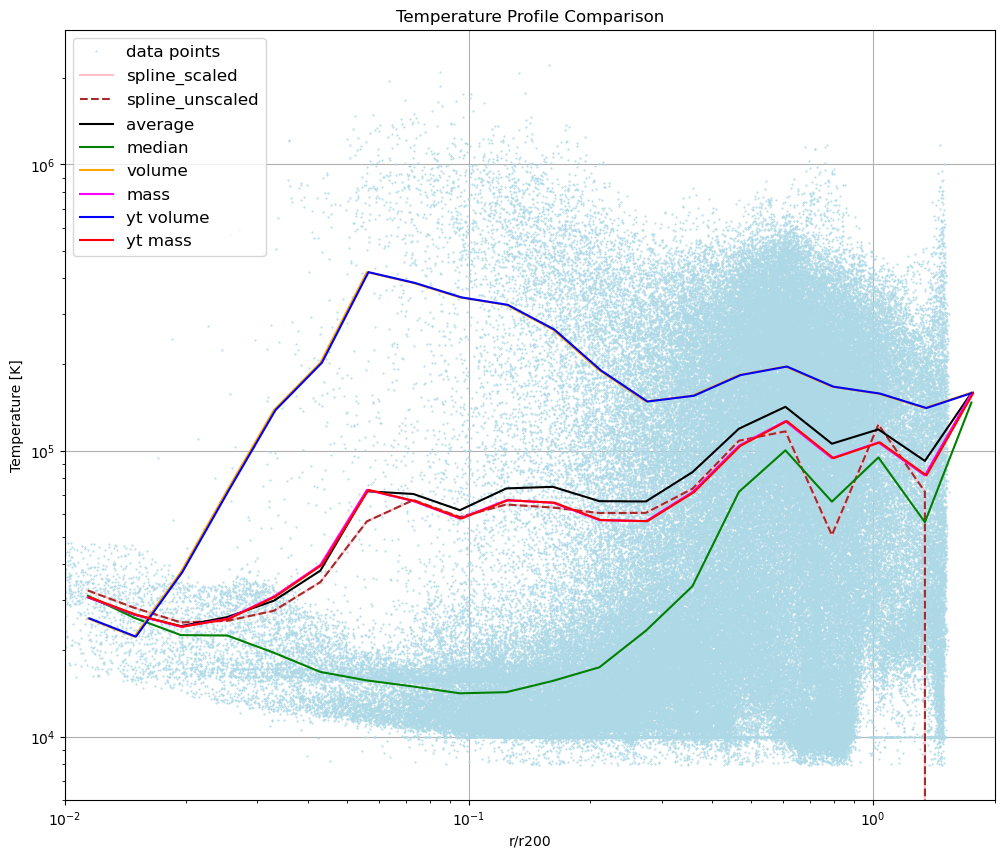

In [16]:
bin_centers = np.sqrt(r_bins[:-1] * r_bins[1:])
#bin_centers = 0.5 * (r_bins[:-1] + r_bins[1:])

plt.figure(figsize=(12, 10)) 

plt.plot(radii, sp["gas", "temperature"].to("K").value, label="data points", color="lightblue", marker=".", markersize = 1, ls="")
plt.plot(bin_centers, temp_scaled, label="spline_scaled", color="pink")
plt.plot(bin_centers, temp_unscaled, label="spline_unscaled", color="brown", ls="--")
plt.plot(bin_centers, temp2, label="average", color="k")
plt.plot(bin_centers, temp3, label="median", color="g")
plt.plot(bin_centers, temp4, label="volume", color="orange")
plt.plot(bin_centers, temp5, label="mass", color="magenta")
plt.plot(x, temp_yt_volume, label="yt volume", color="blue")
plt.plot(x, temp_yt_mass, label="yt mass", color="red")


plt.xlim(1e-2, 2)
#plt.ylim(10**3.7, 10**6.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r/r200")
plt.ylabel("Temperature [K]")
plt.grid()
plt.title("Temperature Profile Comparison")
plt.legend(loc= 2, fontsize=12)
plt.savefig("compare.png", dpi=900)
